In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = 25, 10

In [3]:
!head ./ks-projects-201801.csv

In [4]:
all_data = pd.read_csv('./ks-projects-201801.csv')
BETTER_COLUMN_NAMES = {
    'KickstartedId': 'ID',
    'Categoria': 'category',
    'CateriaPrincipal': 'main_category',
    'FechaLimite': 'deadline',
    'Moneda': 'currency',
    'Meta': 'goal',
    'FechaCreacion': 'launched',
    'TotalInvertido': 'pledged',
    'Estado': 'state',
    'Contribuidores': 'backers',
    'Pais': 'country',
    'TotalInvertidoEnDolar': 'usd pledged',
}
all_data.rename(columns=BETTER_COLUMN_NAMES, inplace=True)

all_data.set_index('ID', inplace=True)

all_data.shape

(378661, 14)

In [5]:
all_data['deadline']=pd.to_datetime(all_data['deadline'])
all_data['launched']=pd.to_datetime(all_data['launched'])
all_data['countday']=all_data['deadline'] - all_data['launched']
all_data['countday']= all_data['countday'].astype('timedelta64[D]')

In [6]:
all_data = all_data.drop(all_data[all_data['state'] == 'live'].index)
all_data = all_data.drop(all_data[all_data['state'] == 'suspended'].index)
all_data = all_data.drop(all_data[all_data['state'] == 'undefined'].index)
all_data = all_data.drop(columns=['name'])
all_data = all_data.drop(columns=['category'])
all_data = all_data.drop(columns=['usd pledged'])

In [7]:
all_data = all_data.drop(all_data[all_data['countday'] > 100].index)
all_data['countday'].fillna(all_data.countday.mean(), inplace=True)

# Variables

## Salida
- state. Valores posibles (suspended,live,undefined,canceled,successfull,state)

## Entrada
- main_category: categoría. Valores posibles (Music,Publishing,Film & Video,Dance,Journalist,Crafts,Photography,Comics,Theater,Fashion,Food,Art,Desing,Techonogy,Games) string
- Countday: Cantidad de dìas entre la diferencia de launched y deadline. float
- backers: Patrocinadores
- country: País del kickstarter
- pledged: invertido.
- usd_pledged_real: inversión en dolares
- usd_goal_real: Meta convertida en dolar.


## No utilizaremos como entradas
- ID:  Esto puede generar sobreentrenamiento
- name: Esto tiene un gran cambio que puede conducir a sobreentrenamiento.
- category: Subcategoría que puede generar duplicidad con el parámetro main_category.
- currency: Se duplica de country y por lo tanto puede generar sobreentrenamiento.
- usd_pledged: inversión en dolares, contiene valores en null, ademas es igual a usd_pledged_real que no tiene valores en null
- deadline y launched: Fecha límite y fecha de lanzamiento del kickstarter se utilizara countday para reflejar la cantidad de dias entre los mismos.

In [8]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(all_data, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

In [9]:
def evaluate_model(model, extract_inputs_outputs_function, include_validation=False):
    sets = [('train', train), ('test', test)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs, outputs = extract_inputs_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        print('Precision:', precision_score(outputs, predictions,average=None))
        print('Recall:', recall_score(outputs, predictions,average=None))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1, 2], ['successful', 'failed', 'canceled'], rotation=45)
        plt.yticks([0, 1, 2], ['successful', 'failed', 'canceled'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

# logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
ds = all_data.copy()
ds = ds.drop(ds[ds['main_category'] == None].index)
ds['main_category'] = ds.main_category.map({'Film & Video':1,'Music':2,'Publishing':3,'Games':4,'Technology':5,'Design':6,'Art':7,'Food':8,'Fashion':9,'Theater':10,'Comics':11,'Photography':12,'Crafts':13,'Journalism':14,'Dance':15})
#ds['country'] = ds.country.map({'US':1,'GB':2,'CA':3,'AU':4,'DE':5,'FR':6,'NL':7,'IT':8,'ES':9,'SE':10,'MX':11,'NZ':12,'DK':13,'IE':14,'CH':15,'NO':16,'BE':17,'AT':18,'HK':19,'SG':20,'N,0"':21,'LU':22,'JP':23})
#ds.state.value_counts()  
ds = ds.drop(ds[ds['countday'] > 100].index)
ds.main_category.count()


370448

In [ ]:
LR_INPUT_COLUMNS = [
    'countday',
    'backers',
    'pledged',
    'country',
    'usd_pledged_real',
    'usd_goal_real',
    'main_category_fv',
    'main_category_m',
    'main_category_p', 
    'main_category_g', 
    'main_category_t', 
    'main_category_d', 
    'main_category_a', 
    'main_category_fd',
    'main_category_fh',
    'main_category_th',
    'main_category_c', 
    'main_category_ph',
    'main_category_cr',
    'main_category_j', 
    'main_category_dc',
]


def lr_extract_inputs_outputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    inputs = dataset.copy()    
    
    inputs = inputs.drop(inputs[inputs['countday'] > 100].index)
    #inputs['main_category'] = inputs.main_category.map({'Film & Video':1,'Music':2,'Publishing':3,'Games':4,'Technology':5,'Design':6,'Art':7,'Food':8,'Fashion':9,'Theater':10,'Comics':11,'Photography':12,'Crafts':13,'Journalism':14,'Dance':15})
    inputs['main_category_fv'] = inputs.main_category == 'Film & Video'
    inputs['main_category_m'] = inputs.main_category == 'Music'
    inputs['main_category_p'] = inputs.main_category == 'Publishing'
    inputs['main_category_g'] = inputs.main_category == 'Games'
    inputs['main_category_t'] = inputs.main_category == 'Technology'
    inputs['main_category_d'] = inputs.main_category == 'Design'
    inputs['main_category_a'] = inputs.main_category == 'Art'
    inputs['main_category_fd'] = inputs.main_category == 'Food'
    inputs['main_category_fh'] = inputs.main_category == 'Fashion'
    inputs['main_category_th'] = inputs.main_category == 'Theater'
    inputs['main_category_c'] = inputs.main_category == 'Comics'
    inputs['main_category_ph'] = inputs.main_category == 'Photography'
    inputs['main_category_cr'] = inputs.main_category == 'Crafts'
    inputs['main_category_j'] = inputs.main_category == 'Journalism'
    inputs['main_category_dc'] = inputs.main_category == 'Dance'

    del inputs['main_category']
    
    inputs['country'] = inputs.country.map({'US':1,'GB':2,'CA':3,'AU':4,'DE':5,'FR':6,'NL':7,'IT':8,'ES':9,'SE':10,'MX':11,'NZ':12,'DK':13,'IE':14,'CH':15,'NO':16,'BE':17,'AT':18,'HK':19,'SG':20,'N,0"':21,'LU':22,'JP':23})
    
    #del inputs['country']
    
    # return the raw numbers
    """
    Outputs in the format supported by the logistic regressor.
    """
    outputs = dataset.state    
 
    return [inputs[LR_INPUT_COLUMNS].values.astype(np.float64), outputs.values]

In [ ]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression()),
])

In [ ]:
inputs, outputs = lr_extract_inputs_outputs(train)
lr_model.fit(inputs,outputs)

In [ ]:
evaluate_model(lr_model, lr_extract_inputs_outputs)

# K nearest neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
K = 10

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [ ]:
inputs, outputs = lr_extract_inputs_outputs(train)
knn_model.fit(inputs,outputs)


In [ ]:
evaluate_model(knn_model, lr_extract_inputs_outputs)

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
# final input columns, in the order we want to use them
TREE_INPUT_COLUMNS = [
    'countday',
    'backers',
    'pledged',
    'country',
    'usd_pledged_real',
    'usd_goal_real',
    'main_category'
]


def tree_extract_inputs_outputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    inputs['main_category'] = inputs.main_category.map({'Film & Video':1,'Music':2,'Publishing':3,'Games':4,'Technology':5,'Design':6,'Art':7,'Food':8,'Fashion':9,'Theater':10,'Comics':11,'Photography':12,'Crafts':13,'Journalism':14,'Dance':15})
    
    inputs['country'] = inputs.country.map({'US':1,'GB':2,'CA':3,'AU':4,'DE':5,'FR':6,'NL':7,'IT':8,'ES':9,'SE':10,'MX':11,'NZ':12,'DK':13,'IE':14,'CH':15,'NO':16,'BE':17,'AT':18,'HK':19,'SG':20,'N,0"':21,'LU':22,'JP':23})
    
    # return the raw numbers
    return [inputs[TREE_INPUT_COLUMNS].values,dataset.state.values]
 

In [14]:
tree_model = DecisionTreeClassifier()

In [23]:
inputs, outputs = tree_extract_inputs_outputs(train)
tree_model.fit(inputs,outputs)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

train ################################################################################
Accuracy: 0.9820037072363094
Precision: [0.95308817 0.97504339 1.        ]
Recall: [0.8705857  0.99163809 0.99993801]



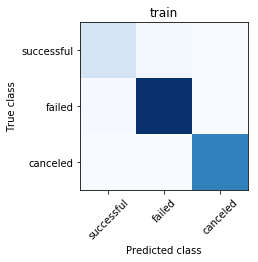

test ################################################################################
Accuracy: 0.8297745984613308
Precision: [0.19082311 0.84612269 0.99241603]
Recall: [0.19407253 0.84334704 0.99237896]



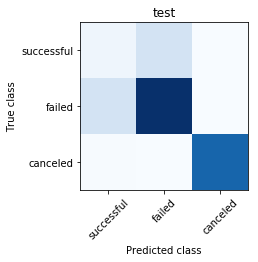

In [24]:
evaluate_model(tree_model, tree_extract_inputs_outputs)

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
forest_model = RandomForestClassifier()

In [ ]:
forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)
inputs, outputs = tree_extract_inputs_outputs(train)
tree_model.fit(inputs,outputs)